In [545]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from catboost import CatBoostClassifier

RANDOM_SEED = 108

## Подгружаем данные

In [653]:
file = '\data_final'
predict = '\predict'

In [654]:
data = pd.read_csv(r'C:\Users\Максим\Dota 2_PY_Project\parse'+file+'.csv')
data['sample'] = 0
data_predict = pd.read_csv(r'C:\Users\Максим\Dota 2_PY_Project\parse'+predict+'.csv')
data_predict['sample'] = 1
data = pd.concat([data, data_predict], ignore_index=True)

In [655]:
data = data.drop(columns=['Unnamed: 0'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10238 entries, 0 to 10237
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   match              10238 non-null  object
 1   pinnacle           10238 non-null  object
 2   parimatch          10238 non-null  object
 3   ggbet              10238 non-null  object
 4   date               10238 non-null  object
 5   tournament         10238 non-null  object
 6   team left          10238 non-null  object
 7   players_left       10238 non-null  object
 8   team right         10238 non-null  object
 9   players_right      10238 non-null  object
 10  ban_left           10238 non-null  object
 11  ban_right          10238 non-null  object
 12  pick_left_team     10238 non-null  object
 13  pick_right_team    10238 non-null  object
 14  result_left_team   5140 non-null   object
 15  result_right_team  5074 non-null   object
 16  score              10238 non-null  objec

## Обработка признаков
### match

In [656]:
data['match_left_team'] = data['match'].apply(lambda x: x.split(' vs ')[0])
data['match_right_team'] = data['match'].apply(lambda x: x.split(' vs ')[1])
data = data.drop(columns=['match'])

In [657]:
data[['match_left_team', 'match_right_team']].head(5)

,match_left_team,match_right_team
0,PuckChamp,Fantastic Five
1,PuckChamp,Fantastic Five
2,Spider Pigzs,Team Empire
3,Spider Pigzs,Team Empire
4,Spider Pigzs,Team Empire


### pinnacle

In [658]:
data = data[data['pinnacle'] != '-'].reset_index(drop=True)
data['pinnacle_left_team'] = data['pinnacle'].apply(
    lambda x: float(x.split('-')[0]))
data['pinnacle_right_team'] = data['pinnacle'].apply(
    lambda x: float(x.split('-')[1]))
data = data.drop(columns=['pinnacle', 'parimatch', 'ggbet'])

In [659]:
def odds_left(team, team_match, pinnacle_left_team, pinnacle_right_team):
    if team == team_match:
        return pinnacle_left_team
    else:
        return pinnacle_right_team


def odds_right(team, team_match, pinnacle_left_team, pinnacle_right_team):
    if team == team_match:
        return pinnacle_right_team
    else:
        return pinnacle_left_team

data['pinnacle_left_map'] = 0 
data['pinnacle_right_map'] = 0

for i in range(len(data)):
    data['pinnacle_left_map'].iloc[i] = odds_left(
        data['team left'].iloc[i], data['match_left_team'].iloc[i], data['pinnacle_left_team'].iloc[i], data['pinnacle_right_team'].iloc[i])
    data['pinnacle_right_map'].iloc[i] = odds_right(
        data['team right'].iloc[i], data['match_right_team'].iloc[i], data['pinnacle_left_team'].iloc[i], data['pinnacle_right_team'].iloc[i])

data = data.drop(columns=['pinnacle_right_team', 'pinnacle_left_team'])
# data = data.drop(columns=['pinnacle_right_map', 'pinnacle_left_map']) 

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### date

In [660]:
def month_rus_to_num(date):
    date = date.lower()
    date = date.split(' ')
    months = {'августа': '8',
              'сентября': '9',
              'октября': '10',
              'ноября': '11',
              'декабря': '12',
              'января': '1',
              'февраля': '2',
              'марта': '3',
              'апреля': '4',
              'мая': '5',
              'июня': '6',
              'июля': '7'}
    return date[3] + ' ' + months[date[1]] + ' ' + date[0] + ' ' + date[2]

In [661]:
data['date'] = data['date'].apply(month_rus_to_num)
data['date'] = data['date'].apply(lambda x: pd.to_datetime(x))

data['date_day'] = data['date'].dt.day
data['date_year'] = data['date'].dt.year
data['date_month'] = data['date'].dt.month
data['date_weekday'] = data['date'].dt.weekday
# data = data.drop(columns=['date'])

### tournament

In [662]:
tournaments = ['ESL', 'DreamLeague', 'MDL', 'BTS', 'Champions League', 'EPIC League', 'Pinnacle',
               'WePlay', 'Realms Collide', 'The International', 'i-League', 'BEYOND', 'OMEGA League',
               'Moon Studio', 'DOTA Summit', 'Hainan', 'Chinese DOTA2', 'Huya', 'The Great American',
               'DPL-CDA', 'Parimatch', 'One Esports', 'Epic Prime', 'China Dota2', 'OGA', 'Dota Pro',
               'StarLadder', 'LB/DOTA', 'SIGUL', 'WeSave', 'GGBET', 'CDA-FDC', 'BLAST', 'Gamers', 'Arena']


def tournament(tour):
    for i in tournaments:
        if i.lower() in tour.lower():
            return i


data['tournament'] = data['tournament'].apply(tournament).fillna('other')

### team left

In [663]:
# удалим наименее популярные команды и матчи
index_delete_match_team_left = []
delete_match_team_left = list(
    data['match_left_team'].value_counts().index[:-135])
for team in delete_match_team_left:
    index_delete_match_team_left.extend(
        data.groupby(by='match_left_team').groups[team])
data = data.loc[data.index.isin(index_delete_match_team_left)]
data = data.reset_index(drop=True)

### players_left

In [664]:
data['players_left'] = data['players_left'].apply(lambda x: x.replace(
    '[', '').replace(']', '').replace("'", '').replace(' ', '').split(','))

### team right

In [665]:
index_delete_match_team_right = []
delete_match_team_right = list(
    data['match_right_team'].value_counts().index[:-135])
for team in delete_match_team_right:
    index_delete_match_team_right.extend(
        data.groupby(by='match_right_team').groups[team])
data = data.loc[data.index.isin(index_delete_match_team_right)]
data = data.reset_index(drop=True)

### players_right

In [666]:
data['players_right'] = data['players_right'].apply(lambda x: x.replace(
    '[', '').replace(']', '').replace("'", '').replace(' ', '').split(','))

### ban_left

In [667]:
data['ban_left'] = data['ban_left'].apply(lambda x: x.replace(
    '[', '').replace(']', '').replace("'", '').replace(' ', '').split(','))

### ban_right

In [668]:
data['ban_right'] = data['ban_right'].apply(lambda x: x.replace(
    '[', '').replace(']', '').replace("'", '').replace(' ', '').split(','))

### pick_left_team

In [669]:
data['pick_left_team'] = data['pick_left_team'].apply(lambda x: x.replace(
    '[', '').replace(']', '').replace("'", '').replace(' ', '').split(','))

### pick_right_team

In [670]:
data['pick_right_team'] = data['pick_right_team'].apply(lambda x: x.replace(
    '[', '').replace(']', '').replace("'", '').replace(' ', '').split(','))

### result_left_team

In [671]:
data['result_left_team'] = data['result_left_team'].fillna(0)
data['result_left_team'] = data['result_left_team'].apply(
    lambda x: 1 if 'Победа' in str(x) else 0)
data = data.drop(columns=['result_right_team'])

### result_right_team

In [672]:
# Оставим только result_left_team

### score

In [673]:
# data['score_left_team'] = data['score'].apply(lambda x: int(x.split(' : ')[0]))
# data['score_right_team'] = data['score'].apply(
#     lambda x: int(x.split(' : ')[1]))
data = data.drop(columns=['score'])

# удалим колонку match
data = data.drop(columns=['match_left_team', 'match_right_team'])

## Подготовка данных к машинному обучению

In [674]:
# Колонки tournament, team left, team right, match_left_team, match_right_team преобразуем с помощью LabelEncoder/TargerEncoder
# Колонки players_lef, players_right, ban_left, ban_right, pick_left_team, pick_right_team преобразуем с помощью get_dummies
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7649 entries, 0 to 7648
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                7649 non-null   datetime64[ns]
 1   tournament          7649 non-null   object        
 2   team left           7649 non-null   object        
 3   players_left        7649 non-null   object        
 4   team right          7649 non-null   object        
 5   players_right       7649 non-null   object        
 6   ban_left            7649 non-null   object        
 7   ban_right           7649 non-null   object        
 8   pick_left_team      7649 non-null   object        
 9   pick_right_team     7649 non-null   object        
 10  result_left_team    7649 non-null   int64         
 11  sample              7649 non-null   int64         
 12  pinnacle_left_map   7649 non-null   float64       
 13  pinnacle_right_map  7649 non-null   float64     

In [675]:
# TargetEncoder
te = TargetEncoder()
data['tournament'] = te.fit_transform(
    data['tournament'], data['result_left_team'])
te = TargetEncoder()
data['team left'] = te.fit_transform(
    data['team left'], data['result_left_team'])
te = TargetEncoder()
data['team right'] = te.fit_transform(
    data['team right'], data['result_left_team'])

In [676]:
# get_duumies
# players left
dummies_players_left = pd.get_dummies(data['players_left'].apply(pd.Series).stack(),prefix='pl_l').sum(level=0)
data = data.drop(columns=['players_left'])
data = pd.concat([data, dummies_players_left], axis=1)
# # players_right
dummies_players_right = pd.get_dummies(data['players_right'].apply(pd.Series).stack(), prefix = 'pl_r').sum(level=0)
data = data.drop(columns=['players_right'])
data = pd.concat([data, dummies_players_right], axis=1)
# # ban_left
dummies_ban_left = pd.get_dummies(data['ban_left'].apply(pd.Series).stack(), prefix = 'b_l').sum(level=0)
data = data.drop(columns=['ban_left'])
data = pd.concat([data, dummies_ban_left], axis=1)
# # ban_right
dummies_ban_right = pd.get_dummies(data['ban_right'].apply(pd.Series).stack(), prefix = 'b_r').sum(level=0)
data = data.drop(columns=['ban_right'])
data = pd.concat([data, dummies_ban_right], axis=1)
# pick_left_team
dummies_pick_left_team = pd.get_dummies(data['pick_left_team'].apply(pd.Series).stack(), prefix = 'p_l').sum(level=0)
data = data.drop(columns=['pick_left_team'])
data = pd.concat([data, dummies_pick_left_team], axis=1)
# pick_right_team
dummies_pick_right_team = pd.get_dummies(data['pick_right_team'].apply(pd.Series).stack(), prefix = 'p_r').sum(level=0)
data = data.drop(columns=['pick_right_team'])
data = pd.concat([data, dummies_pick_right_team], axis=1)

In [677]:
# удалим дубликаты
data = data.drop_duplicates()

## Сплит X, y

In [678]:
X = data[data['sample'] == 0].drop(columns=['result_left_team', 'pinnacle_left_map', 'pinnacle_right_map'])
X_predict = data[data['sample'] == 1].drop(columns=['result_left_team', 'pinnacle_left_map', 'pinnacle_right_map'])
X = X.drop(columns=['sample'])
X_predict = X_predict.drop(columns=['sample'])
y = data[data['sample'] != 1]['result_left_team']

In [679]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

## Машинное обучение
### Базовая модель

In [57]:
# model = DecisionTreeClassifier()
# model.fit(X_train, y_train)

In [58]:
# probs = model.predict_proba(X_test)
# y_pred = model.predict(X_test)
# probs = probs[:,1]

# fpr, tpr, threshold = roc_curve(y_test, probs)
# roc_auc = roc_auc_score(y_test, probs)

# fig, ax = plt.subplots(figsize=(10,5))
# plt.plot([0, 1], label='Baseline', linestyle='--')
# plt.plot(fpr, tpr, label = 'Regression')
# ax.set_title('Logistic Regression ROC AUC = %0.3f'%roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc='lower right')

In [59]:
# print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 4)))
# print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 4)))
# print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 4)))
# print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

In [60]:
# # Визуализация confusion matrix:
# sns.set_context(context='paper', font_scale=2, rc=None)
# group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
# group_counts = ['{0:0.0f}'.format(value) for value in
#                 confusion_matrix(y_test, y_pred).flatten()]
# labels = [f'{v1}\n{v2}' for v1, v2 in
#           zip(group_names, group_counts)]
# labels = np.asarray(labels).reshape(2, 2)
# ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Greens')
# ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
# plt.show()

### CatBoostClassifier

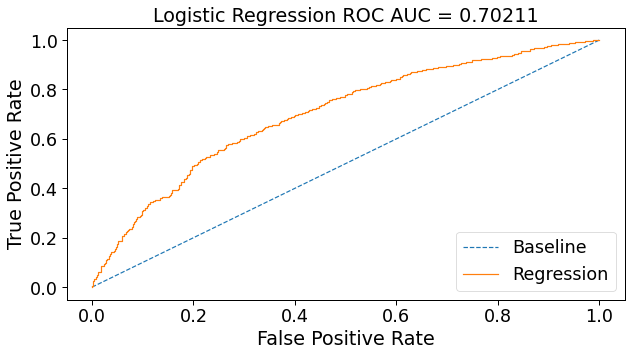

In [70]:
cat = CatBoostClassifier(n_estimators=5000,
                         depth=3,
                         logging_level='Silent')

cat.fit(X_train, y_train)
probs = cat.predict_proba(X_test)
y_pred = cat.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

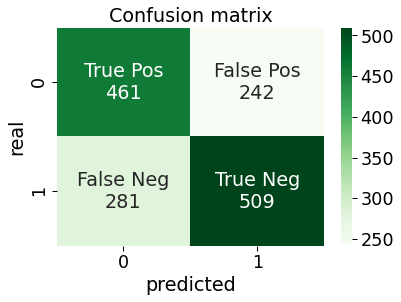

In [68]:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Greens')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')
plt.show()

In [427]:
# for feature, score in zip(X.columns, cat.feature_importances_):
#     print(feature, ':', score)

### Predict

In [574]:
probs_pred = cat.predict_proba(X_predict)
y_pred_pred = cat.predict(X_predict)
probs_pred = probs_pred[:,1]

In [575]:
probs_pred

array([], dtype=float64)

In [576]:
X_probs_predict = X_predict.copy()
X_probs_predict['probs_pred_left'] = np.round(probs_pred,4)

def predict(prob):
    if prob > 0.55:
        return 1
    elif prob < 0.45:
        return 0
    else:
        return 'skip'
X_probs_predict['probs_pred_right'] = X_probs_predict['probs_pred_left'].apply(lambda x: 1-x)

X_probs_predict['predict_pred_left'] = X_probs_predict['probs_pred_left'].apply(predict)
X_probs_predict[['team left', 'team right', 'probs_pred_left', 'probs_pred_right']]

,team left,team right,probs_pred_left,probs_pred_right
